## 1. Imports from libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing import image
from PIL import Image

## 2. Organizing Training and Testing Dataframes

In [2]:
# Selecting Dataset Folder Paths
dir_ = Path('/Users/kanishkhajaisankar/Downloads/Projects/Self_driving_car/Vehicle_Detection/data')
filepaths = list(dir_.glob(r'**/*.png'))
# Mapping the labels
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Paths & labels femalee eyes
filepaths = pd.Series(filepaths, name = 'File').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenating...
df = pd.concat([filepaths, labels], axis=1)

df = df.sample(frac = 1, random_state = 56).reset_index(drop = True)

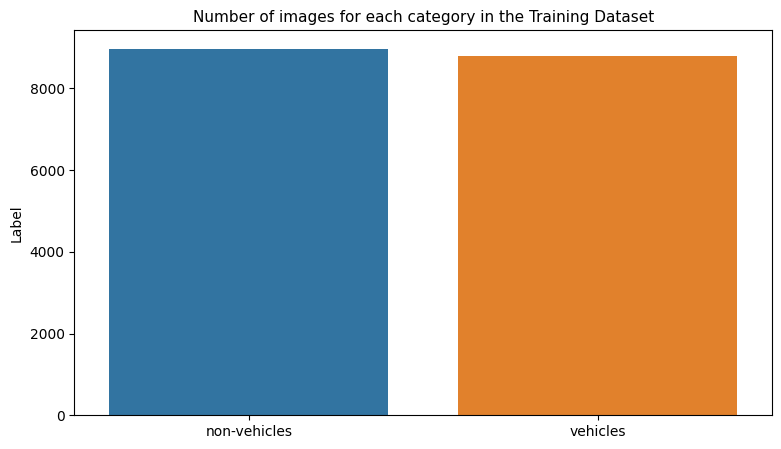

In [3]:
vc = df['Label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()

## 3. Observing the images

Text(0.5, 1.0, 'non-vehicles')

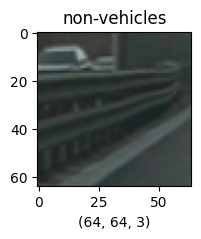

In [4]:
figure = plt.figure(figsize=(2,2))
x = plt.imread(df["File"][34])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][34])

Text(0.5, 1.0, 'vehicles')

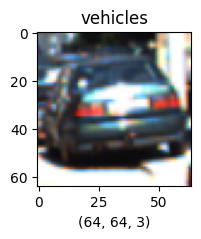

In [5]:
figure = plt.figure(figsize=(2, 2))
x = plt.imread(df["File"][15])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][15])

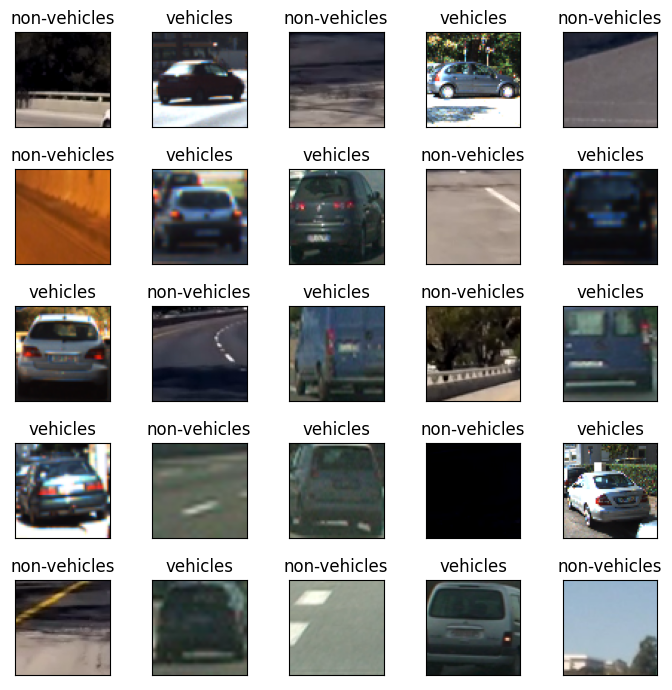

In [6]:
fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["File"][i]))
    ax.set_title(df["Label"][i])
plt.tight_layout()
plt.show()

In [7]:
trainset_df, testset_df = train_test_split(df, train_size = 0.80, random_state = 42)

display(trainset_df.head())

testset_df.head()

,File,Label
15610,/Users/kanishkhajaisankar/Downloads/Projects/S...,non-vehicles
5230,/Users/kanishkhajaisankar/Downloads/Projects/S...,non-vehicles
15224,/Users/kanishkhajaisankar/Downloads/Projects/S...,vehicles
83,/Users/kanishkhajaisankar/Downloads/Projects/S...,non-vehicles
14570,/Users/kanishkhajaisankar/Downloads/Projects/S...,non-vehicles


,File,Label
15314,/Users/kanishkhajaisankar/Downloads/Projects/S...,non-vehicles
11728,/Users/kanishkhajaisankar/Downloads/Projects/S...,non-vehicles
10379,/Users/kanishkhajaisankar/Downloads/Projects/S...,vehicles
6323,/Users/kanishkhajaisankar/Downloads/Projects/S...,vehicles
5155,/Users/kanishkhajaisankar/Downloads/Projects/S...,vehicles


In [8]:
# converting the Label to a numeric format for testing later...
LE = LabelEncoder()

y_test = LE.fit_transform(testset_df["Label"])

In [9]:
# Viewing data in training dataset
print('Training Dataset:')

print(f'Number of images: {trainset_df.shape[0]}')

print(f'Number of images with malee eyes: {trainset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {trainset_df["Label"].value_counts()[1]}\n')

# Viewing data in test dataset
print('Test Dataset:')

print(f'Number of images: {testset_df.shape[0]}')

print(f'Number of images with malee eyes: {testset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {testset_df["Label"].value_counts()[1]}\n')

Training Dataset:
Number of images: 14208
Number of images with malee eyes: 7155
Number of images with femalee eyes: 7053

Test Dataset:
Number of images: 3552
Number of images with malee eyes: 1813
Number of images with femalee eyes: 1739



In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
print("Preparing the training dataset ...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

print("Preparing the validation dataset ...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")

print("Preparing the test dataset ...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = testset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    shuffle = False,
    batch_size = 32)

print('Data generators are ready!')

Preparing the training dataset ...
Found 12788 validated image filenames belonging to 2 classes.
Preparing the validation dataset ...
Found 1420 validated image filenames belonging to 2 classes.
Preparing the test dataset ...
Found 3552 validated image filenames belonging to 2 classes.
Data generators are ready!


In [12]:
# Callbacks
cb = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 5, restore_best_weights = True)]

In [13]:
CNN_base_inc = InceptionV3(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-12-21 12:37:39.032716: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-21 12:37:39.033135: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


87910968/87910968 [==============================] - 9s 0us/step


In [14]:
for layer in CNN_base_inc.layers:
    layer.trainable = False

In [15]:
x = layers.Flatten()(CNN_base_inc.output)

In [16]:
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(1, activation='sigmoid')(x)

CNN_inc = Model(CNN_base_inc.input, x)

In [19]:
# Compilation
CNN_inc.compile(optimizer = RMSprop(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_inc_history = CNN_inc.fit(training_set, epochs = 25, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_inc = end - start
print ('\nTraining and validation time is: ', time_CNN_inc)

Epoch 1/25


2022-12-21 12:42:40.682677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - ETA: 0s - loss: 0.0551 - accuracy: 0.9821

2022-12-21 12:42:57.177025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - 22s 48ms/step - loss: 0.0551 - accuracy: 0.9821 - val_loss: 0.0728 - val_accuracy: 0.9775
Epoch 2/25
400/400 [==============================] - 17s 42ms/step - loss: 0.0522 - accuracy: 0.9829 - val_loss: 0.0587 - val_accuracy: 0.9782
Epoch 3/25
400/400 [==============================] - 16s 40ms/step - loss: 0.0533 - accuracy: 0.9819 - val_loss: 0.0666 - val_accuracy: 0.9782
Epoch 4/25
400/400 [==============================] - 16s 39ms/step - loss: 0.0559 - accuracy: 0.9807 - val_loss: 0.0533 - val_accuracy: 0.9824
Epoch 5/25
400/400 [==============================] - 16s 40ms/step - loss: 0.0529 - accuracy: 0.9834 - val_loss: 0.0465 - val_accuracy: 0.9831
Epoch 6/25
400/400 [==============================] - 16s 41ms/step - loss: 0.0477 - accuracy: 0.9824 - val_loss: 0.0523 - val_accuracy: 0.9768
Epoch 7/25
400/400 [==============================] - 16s 39ms/step - loss: 0.0489 - accuracy: 0.9831 - val_loss: 0.0467 - val_accuracy: 0.9859
Epo

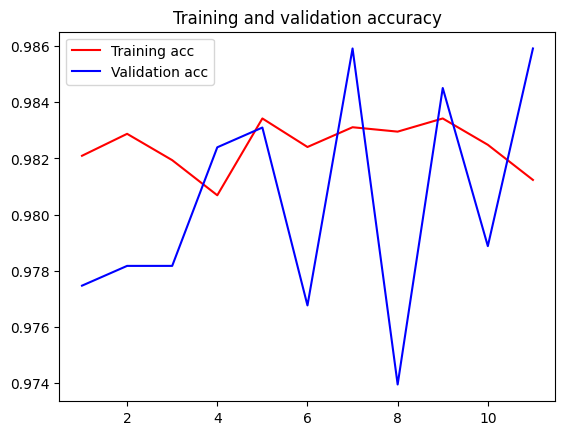

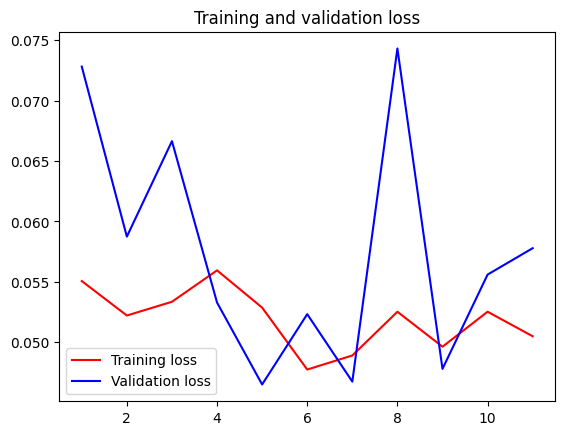

In [39]:
acc = CNN_inc_history.history['accuracy']
val_acc = CNN_inc_history.history['val_accuracy']
loss = CNN_inc_history.history['loss']
val_loss = CNN_inc_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

###### Step 6 - Viewing results and generating forecasts

In [21]:
score_inc = CNN_inc.evaluate(test_set)
print("Test Loss:", score_inc[0])
print("Test Accuracy:", score_inc[1])

111/111 [==============================] - 4s 32ms/step - loss: 0.0293 - accuracy: 0.9918
Test Loss: 0.029288167133927345
Test Accuracy: 0.9918355941772461


In [22]:
y_pred_inc = CNN_inc.predict(test_set)
y_pred_inc = np.round(y_pred_inc)

recall_inc = recall_score(y_test, y_pred_inc)
precision_inc = precision_score(y_test, y_pred_inc)
f1_inc = f1_score(y_test, y_pred_inc)
roc_inc = roc_auc_score(y_test, y_pred_inc)

2022-12-21 12:46:45.499995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 5s 31ms/step


In [23]:
print(classification_report(y_test, y_pred_inc))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1813
           1       0.99      0.99      0.99      1739

    accuracy                           0.99      3552
   macro avg       0.99      0.99      0.99      3552
weighted avg       0.99      0.99      0.99      3552



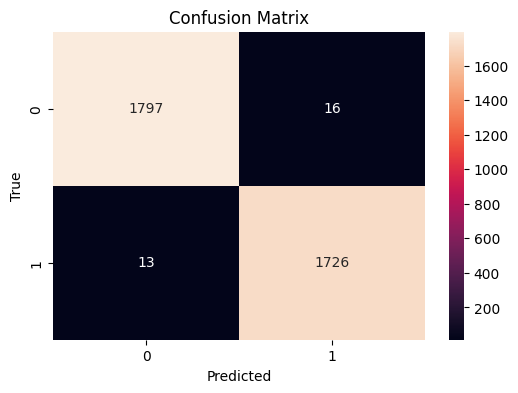

In [24]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_inc),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [25]:
CNN_base_xcep = Xception(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')
CNN_base_xcep.trainable = False

83683744/83683744 [==============================] - 8s 0us/step


In [26]:
CNN_xcep = Sequential()
CNN_xcep.add(CNN_base_xcep)
CNN_xcep.add(GlobalAveragePooling2D())
CNN_xcep.add(Dense(128))
CNN_xcep.add(Dropout(0.1))
CNN_xcep.add(Dense(1, activation = 'sigmoid'))

CNN_xcep.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,123,881
Trainable params: 262,401
Non-trainable params: 20,861,480
______________________________________

In [27]:
plot_model(CNN_xcep, show_layer_names = True , show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
# Compilation
CNN_xcep.compile(optimizer='adam', loss = 'binary_crossentropy',metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_xcep_history = CNN_xcep.fit(training_set, epochs = 25, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_xcep = end - start
print ('\nTraining and validation time: ', time_CNN_xcep)

Epoch 1/25


2022-12-21 12:47:26.723442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0.9644

2022-12-21 12:48:00.917077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - 40s 93ms/step - loss: 0.1278 - accuracy: 0.9644 - val_loss: 0.0959 - val_accuracy: 0.9810
Epoch 2/25
400/400 [==============================] - 35s 87ms/step - loss: 0.0693 - accuracy: 0.9812 - val_loss: 0.0612 - val_accuracy: 0.9838
Epoch 3/25
400/400 [==============================] - 35s 87ms/step - loss: 0.0669 - accuracy: 0.9826 - val_loss: 0.0418 - val_accuracy: 0.9915
Epoch 4/25
400/400 [==============================] - 34s 86ms/step - loss: 0.0542 - accuracy: 0.9862 - val_loss: 0.0522 - val_accuracy: 0.9852
Epoch 5/25
400/400 [==============================] - 34s 86ms/step - loss: 0.0523 - accuracy: 0.9848 - val_loss: 0.0437 - val_accuracy: 0.9880
Epoch 6/25
400/400 [==============================] - 34s 85ms/step - loss: 0.0463 - accuracy: 0.9873 - val_loss: 0.0491 - val_accuracy: 0.9852
Epoch 7/25
400/400 [==============================] - 34s 86ms/step - loss: 0.0527 - accuracy: 0.9855 - val_loss: 0.0498 - val_accuracy: 0.9845
Epo

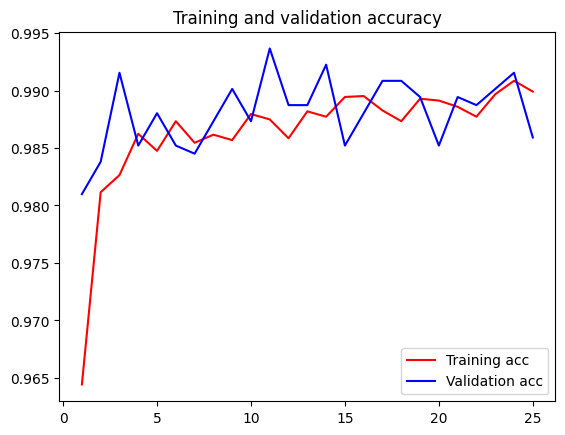

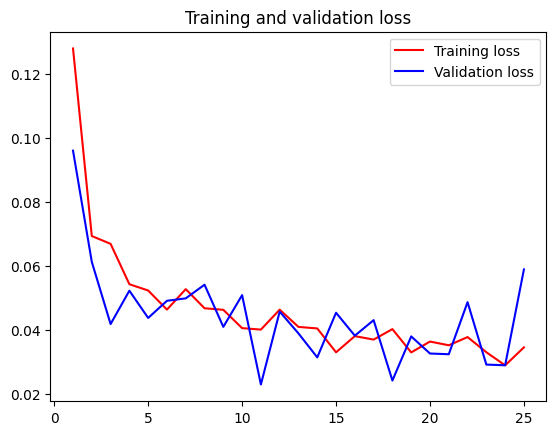

In [29]:
acc = CNN_xcep_history.history['accuracy']
val_acc = CNN_xcep_history.history['val_accuracy']
loss = CNN_xcep_history.history['loss']
val_loss = CNN_xcep_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

###### Step 8 - Viewing results and generating forecasts

In [30]:
score_xcep = CNN_xcep.evaluate(test_set)
print("Test Loss:", score_xcep[0])
print("Test Accuracy:", score_xcep[1])

111/111 [==============================] - 8s 74ms/step - loss: 0.0193 - accuracy: 0.9918
Test Loss: 0.019278842955827713
Test Accuracy: 0.9918355941772461


In [31]:
y_pred_xcep = CNN_xcep.predict(test_set)
y_pred_xcep = np.round(y_pred_xcep)

recall_xcep = recall_score(y_test, y_pred_xcep)
precision_xcep = precision_score(y_test, y_pred_xcep)
f1_xcep = f1_score(y_test, y_pred_xcep)
roc_xcep = roc_auc_score(y_test, y_pred_xcep)

2022-12-21 13:02:22.519674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 10s 73ms/step


In [32]:
print(classification_report(y_test, y_pred_xcep))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1813
           1       1.00      0.99      0.99      1739

    accuracy                           0.99      3552
   macro avg       0.99      0.99      0.99      3552
weighted avg       0.99      0.99      0.99      3552



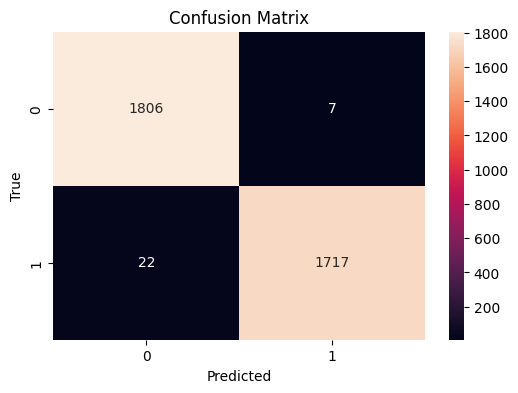

In [33]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_xcep),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [34]:
CNN_base_mobilenet = MobileNet(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

In [35]:
for layer in CNN_base_mobilenet.layers:
    layer.trainable = False

In [36]:
CNN_mobilenet = Sequential()
CNN_mobilenet.add(BatchNormalization(input_shape = (75, 75, 3)))
CNN_mobilenet.add(CNN_base_mobilenet)
CNN_mobilenet.add(BatchNormalization())
CNN_mobilenet.add(GlobalAveragePooling2D())
CNN_mobilenet.add(Dropout(0.5))
CNN_mobilenet.add(Dense(1, activation = 'sigmoid'))

CNN_mobilenet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_98 (Bat  (None, 75, 75, 3)        12        
 chNormalization)                                                
                                                                 
 mobilenet_1.00_224 (Functio  (None, 2, 2, 1024)       3228864   
 nal)                                                            
                                                                 
 batch_normalization_99 (Bat  (None, 2, 2, 1024)       4096      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1024)             

In [37]:
plot_model(CNN_mobilenet, show_layer_names = True , show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [38]:
# Compilation
CNN_mobilenet.compile(optimizer='adam',loss = 'binary_crossentropy', metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_mobilenet_history = CNN_mobilenet.fit(training_set, epochs = 25, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_mobilenet = end - start
print ('\nTraining and validation time: ', time_CNN_mobilenet)

Epoch 1/25


2022-12-21 13:28:17.576008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - ETA: 0s - loss: 0.1659 - accuracy: 0.9335

2022-12-21 13:28:40.766067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - 27s 56ms/step - loss: 0.1659 - accuracy: 0.9335 - val_loss: 0.0472 - val_accuracy: 0.9845
Epoch 2/25
400/400 [==============================] - 19s 48ms/step - loss: 0.0851 - accuracy: 0.9701 - val_loss: 0.0358 - val_accuracy: 0.9880
Epoch 3/25
400/400 [==============================] - 19s 47ms/step - loss: 0.0756 - accuracy: 0.9722 - val_loss: 0.0371 - val_accuracy: 0.9852
Epoch 4/25
400/400 [==============================] - 18s 46ms/step - loss: 0.0685 - accuracy: 0.9754 - val_loss: 0.0389 - val_accuracy: 0.9866
Epoch 5/25
400/400 [==============================] - 19s 48ms/step - loss: 0.0618 - accuracy: 0.9773 - val_loss: 0.0295 - val_accuracy: 0.9887
Epoch 6/25
400/400 [==============================] - 18s 46ms/step - loss: 0.0641 - accuracy: 0.9763 - val_loss: 0.0301 - val_accuracy: 0.9887
Epoch 7/25
400/400 [==============================] - 22s 55ms/step - loss: 0.0595 - accuracy: 0.9804 - val_loss: 0.0246 - val_accuracy: 0.9923
Epo

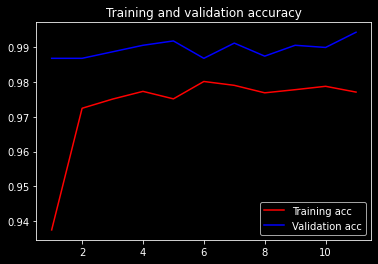

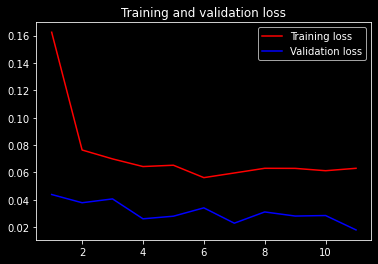

In [ ]:
acc = CNN_mobilenet_history.history['accuracy']
val_acc = CNN_mobilenet_history.history['val_accuracy']
loss = CNN_mobilenet_history.history['loss']
val_loss = CNN_mobilenet_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

###### Step 8 - Viewing results and generating forecasts

In [ ]:
score_mn = CNN_mobilenet.evaluate(test_set)
print("Test Loss:", score_mn[0])
print("Test Accuracy:", score_mn[1])

56/56 [==============================] - 4s 76ms/step - loss: 0.0151 - accuracy: 0.9944
Test Loss: 0.015131447464227676
Test Accuracy: 0.994369387626648


In [ ]:
y_pred_mn = CNN_mobilenet.predict(test_set)
y_pred_mn = np.round(y_pred_mn)

recall_mn = recall_score(y_test, y_pred_mn)
precision_mn = precision_score(y_test, y_pred_mn)
f1_mn = f1_score(y_test, y_pred_mn)
roc_mn = roc_auc_score(y_test, y_pred_mn)

In [ ]:
print(classification_report(y_test, y_pred_mn))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       902
           1       1.00      0.99      0.99       874

    accuracy                           0.99      1776
   macro avg       0.99      0.99      0.99      1776
weighted avg       0.99      0.99      0.99      1776



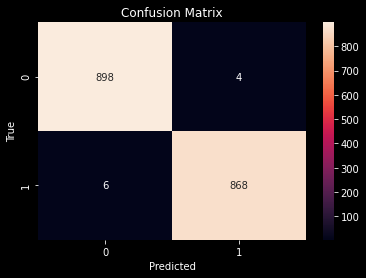

In [ ]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_mn),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

## 9. Viewing the results of all models

In [ ]:
models= [('Inception', time_CNN_inc, np.mean(CNN_inc_history.history['accuracy']), np.mean(CNN_inc_history.history['val_accuracy'])),
         ('Xception', time_CNN_xcep, np.mean(CNN_xcep_history.history['accuracy']), np.mean(CNN_xcep_history.history['val_accuracy'])),
         ('MobileNet', time_CNN_mobilenet, np.mean(CNN_mobilenet_history.history['accuracy']), np.mean(CNN_mobilenet_history.history['val_accuracy']))]

df_all_models = pd.DataFrame(models, columns = ['Model', 'Time', 'Training accuracy (%)', 'Validation Accuracy (%)'])

df_all_models

,Model,Time,Training accuracy (%),Validation Accuracy (%)
0,Inception,0 days 00:26:13.328518,0.979391,0.981827
1,Xception,0 days 00:13:25.486802,0.985879,0.988289
2,MobileNet,0 days 00:10:03.406209,0.973408,0.989589


In [ ]:
models = [('Inception', score_inc[1], recall_inc, precision_inc, f1_inc, roc_inc),
          ('Xception', score_xcep[1], recall_xcep, precision_xcep, f1_xcep, roc_xcep),
          ('MobileNet', score_mn[1], recall_mn, precision_mn, f1_mn, roc_mn)]

df_all_models_testset = pd.DataFrame(models, columns = ['Model', 'Test accuracy (%)', 'Recall (%)', 'Precision (%)', 'F1 (%)', 'AUC'])

df_all_models_testset

,Model,Test accuracy (%),Recall (%),Precision (%),F1 (%),AUC
0,Inception,0.992117,0.993135,0.990868,0.992000,0.992133
1,Xception,0.991554,0.988558,0.994246,0.991394,0.991508
2,MobileNet,0.994369,0.993135,0.995413,0.994273,0.994350


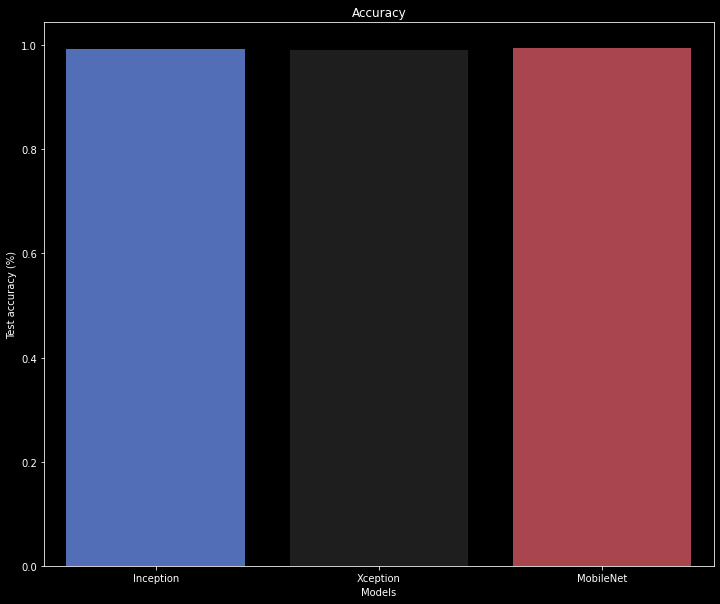

In [ ]:
plt.subplots(figsize=(12, 10))
sns.barplot(y = df_all_models_testset['Test accuracy (%)'], x = df_all_models_testset['Model'], palette = 'icefire')
plt.xlabel("Models")
plt.title('Accuracy')
plt.show()

In [ ]:
r_probs = [0 for _ in range(len(y_test))]
r_auc = roc_auc_score(y_test, r_probs)
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)

fpr_inc, tpr_inc, _ = roc_curve(y_test, y_pred_inc)
fpr_xcep, tpr_xcep, _ = roc_curve(y_test, y_pred_xcep)
fpr_mn, tpr_mn, _ = roc_curve(y_test, y_pred_mn)

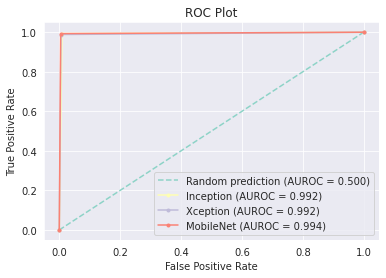

In [ ]:
sns.set_style('darkgrid')

plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)

plt.plot(fpr_inc, tpr_inc, marker='.', label='Inception (AUROC = %0.3f)' % roc_inc)
plt.plot(fpr_xcep, tpr_xcep, marker='.', label='Xception (AUROC = %0.3f)' % roc_xcep)
plt.plot(fpr_mn, tpr_mn, marker='.', label='MobileNet (AUROC = %0.3f)' % roc_mn)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()

In [ ]:
test_set.class_indices

{'non-vehicles': 0, 'vehicles': 1}

In [ ]:

fig, axes = plt.subplots(nrows = 4,
                         ncols = 4,
                         figsize = (15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testset_df["File"].iloc[i]))
    ax.set_title(f"True: {testset_df.Label.iloc[i]}\nInception: {y_pred_inc[i]}\nXception: {y_pred_xcep[i]}\nMobileNet: {y_pred_mn[i]}")
plt.tight_layout()
plt.show()